# III.A: Validation With External Software

In [2]:
import os
import numpy as np
from pytomography.algorithms import BSREM
from pytomography.io.SPECT import simind
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors import SPECTSystemMatrix
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from scipy.ndimage import zoom
import torch

/tmp/ipykernel_30033/2184981132.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Change this to where data is saved

In [3]:
datapath = '/disk1/pytomography_paper_data/'

Open ground truth image

In [4]:
GT = np.fromfile(os.path.join(datapath, 'simind', 'body1_Lu177_T2.bin'), dtype=np.float32)
GT = GT.reshape((751,512,512))
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))
GT = zoom(GT, (128/512, 128/512, 384/767), order=0, mode='nearest')
calib = 0.21089022221130554 #calibration constant from SIMIND output file

In [5]:
CT = simind.get_attenuation_map(os.path.join(datapath, 'simind', 'body1.hct'))

In [9]:
CT.shape

torch.Size([1, 128, 128, 384])

Ti

In [16]:
CT[0,25,64,250]

tensor(0.1235, device='cuda:0')

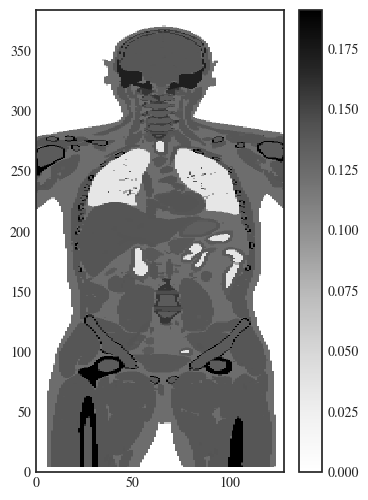

In [14]:
plt.figure(figsize=(4,6))
plt.pcolormesh(CT[0,:,64].cpu().T)
plt.colorbar()

1. Reconstruct using PyTomography

In [6]:
headerfile = os.path.join(datapath, 'simind', 'body1t2ew6_tot_w2.hdr')
object_meta, proj_meta = simind.get_metadata(headerfile)
photopeak = simind.get_projections(headerfile)
CT = simind.get_attenuation_map(os.path.join(datapath, 'simind', 'body1.hct'))
att_transform = SPECTAttenuationTransform(CT)
psf_meta = simind.get_psfmeta_from_header(headerfile)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta,
            n_parallel=15)
reconstruction_algorithm = OSEMBSR(
            projections = photopeak,
            system_matrix = system_matrix)
reconstructed_object = reconstruction_algorithm(n_iters=2, n_subsets=8)
reconstructed_object = reconstructed_object[0].cpu().numpy() * calib

2. Open reconstructed STIR file (obtained using `OSMAPOSL recon.par` in `test_files` folder)

In [7]:
reconstructed_object_stir = np.fromfile(os.path.join(datapath, 'simind', 'OSEM_16.v'), dtype=np.float32)
reconstructed_object_stir = np.transpose(reconstructed_object_stir.reshape(384,128,128)[::-1,::-1,::-1], (2,1,0)) * calib

Slices and profile indices

In [8]:
s = 64
l1 = 167
l2 = 250
l3 = 315
#delta = reconstructed_object - reconstructed_object_stir

Plotting functions

In [9]:
def plot_differences(ax,l, uppery=None, lowery=None):
    #plt.plot(GT[:,64,l], color='k', lw=2)
    stir = reconstructed_object_stir[:,64,l]
    pytomo = reconstructed_object[:,64,l]
    diff = stir - pytomo
    ax.plot(np.arange(128)*0.3,stir, marker='', ls='-', lw=1.5, color='k', label='STIR')
    ax.plot(np.arange(128)*0.3,pytomo, marker='', ls='--', lw=2.5, color='lightblue', label='PyTomography')
    ax.plot(np.arange(128)*0.3,diff, marker='', ls='-', lw=2.5, color='r', label='Difference', zorder=-10000)
    #ax.plot(np.arange(128)*0.3,np.abs(reconstructed_object[:,s,l]-reconstructed_object_stir[:,s,l])*100, ls='dotted', color='dimgrey', label='Difference (x100)')
    #plt.plot(delta[:,64,l])
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 1
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.1
    im = ax.pcolormesh(ob[:,64].T, cmap=cmap, vmax=vmax)
    ax.axhline(l1, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2, ls='--', color=tcol, lw=0.8)
    ax.axhline(l3, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l3+7, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2+7, '2', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l1+7, '3', ha='center', va='center', color=tcol, size=13)
    return im

Plot

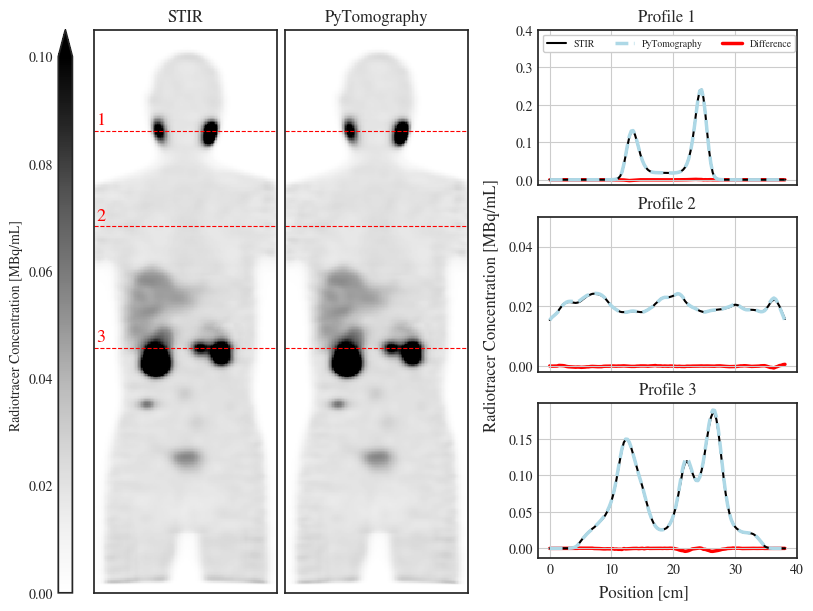

In [16]:
mode = 'bw'
fig = plt.figure(constrained_layout=True, figsize=(8,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.85,0.6))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('STIR')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_stir, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object, axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Radiotracer Concentration [MBq/mL]', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=3, ncols=1, sharex=True)
plot_differences(axes_r[0],l3)
axes_r[0].set_title('Profile 1')
axes_r[0].set_ylim(top=0.4)
axes_r[0].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=7, ncol=3)
plot_differences(axes_r[1],l2, uppery=0.05, lowery=-0.002)
axes_r[1].set_title('Profile 2')
plot_differences(axes_r[2],l1)
axes_r[2].set_title('Profile 3')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Radiotracer Concentration [MBq/mL]')
plt.savefig('images/figure2.jpg', dpi=300)

Statistics computed in paper:

In [11]:
mask = reconstructed_object>0.05

* Maximum error

In [12]:
np.max((reconstructed_object[mask] - reconstructed_object_stir[mask]) / reconstructed_object_stir[mask] * 100)

4.7675953

* RMSE

In [13]:
np.sqrt(((reconstructed_object - reconstructed_object_stir) ** 2).mean())

0.00034735375

* SSIM

In [14]:
r1 = torch.tensor(reconstructed_object).unsqueeze(0).unsqueeze(0)
r2 = torch.tensor(reconstructed_object_stir).unsqueeze(0).unsqueeze(0)
ssim = StructuralSimilarityIndexMeasure()
ssim(r1,r2).item()

0.9999635815620422